In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf


In [5]:
# Define directories for training and test data
train_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Train_Data"
test_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Test_Data"

In [6]:

# Step 2: Load and Preprocess Training Data
IMG_SIZE = (128, 128)
ALLOWED_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

# Function to load training data
def load_data(train_dir):
    images = []
    labels = []
    label_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5}

    for folder in os.listdir(train_dir):
        folder_path = os.path.join(train_dir, folder)
        if os.path.isdir(folder_path) and folder in label_map:
            for img_name in os.listdir(folder_path):
                if not any(img_name.lower().endswith(ext) for ext in ALLOWED_EXTENSIONS):
                    continue
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, IMG_SIZE)
                    images.append(img)
                    labels.append(label_map[folder])
    return np.array(images), np.array(labels)


In [7]:

# Load training data
if os.path.exists(train_dir):
    images, labels = load_data(train_dir)
    print(f"Loaded {len(images)} images.")
    print(f"Shape of images array: {images.shape}")
    print(f"Shape of labels array: {labels.shape}")


Loaded 2516 images.
Shape of images array: (2516, 128, 128, 3)
Shape of labels array: (2516,)


In [8]:
# Step 3: Train-Test Split
labels = labels - 1  # Adjust labels to be 0-based
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Advanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:

# Step 4: Define the Model Using ResNet50
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Define model architecture with added regularization
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer='l2'),  # Increased neurons and added L2 regularization
    Dropout(0.4),  # Increased dropout rate
    Dense(512, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # Assuming 5 classes
])



In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,905,361 (659.58 MB)

 Trainable params: 57,617,413 (219.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 115,234,828 (439.59 MB)

In [11]:

# Compile the model with AdamW optimizer
model.compile(optimizer=AdamW(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Training the Model Once
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Train the model with data augmentation, class weights, and callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val),
                    epochs=40,
                    class_weight=class_weights,
                    callbacks=[reduce_lr, early_stopping, checkpoint])


# Step 6: Load and Preprocess Test Data
def load_test_data(test_dir):
    test_images = []
    test_ids = []
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            test_images.append(img)
            test_ids.append(img_name.split('.')[0])

    print(f"Loaded {len(test_images)} images.")

    return np.array(test_images), test_ids

# Load test data
test_images, test_ids = load_test_data(test_dir)

# Normalize test data
test_images = test_images / 255.0

# Step 7: Make Predictions using the saved best model
model.load_weights('best_resnet_model.keras')
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Adjust to match original labels


Epoch 1/40


c:\Users\ganga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.2542 - loss: 29.0115 - val_accuracy: 0.3532 - val_loss: 28.3333 - learning_rate: 1.0000e-04
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3098 - loss: 26.4185 - val_accuracy: 0.1825 - val_loss: 26.0324 - learning_rate: 1.0000e-04
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3568 - loss: 24.5633 - val_accuracy: 0.2897 - val_loss: 50.6256 - learning_rate: 1.0000e-04
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3859 - loss: 23.0181 - val_accuracy: 0.0734 - val_loss: 30.0198 - learning_rate: 1.0000e-04
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3951 - loss: 21.4693 - val_accuracy: 0.3710 - val_loss: 25.6823 - learning_rate: 1.0000e-04
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4068 - loss: 20.0651 - val_accuracy: 0.2222 - val_loss: 20.6478 - learning_rate: 1.0000e-04
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.4339

ModuleNotFoundError: No module named 'google.colab'

In [23]:

# Step 8: Create Submission File
submission = pd.DataFrame({
    'ID': test_ids,
    'Predictions': predicted_classes
})

# Save submission file
submission.to_csv('submission_28_09.csv', index=False)


In [24]:
#Code to find number of images in each class
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 241, 1: 286, 2: 585, 3: 727, 4: 173}

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step
Unique predicted classes: [0]
Shape of y_val: (504,)
Unique true classes: [0 1 2 3 4]


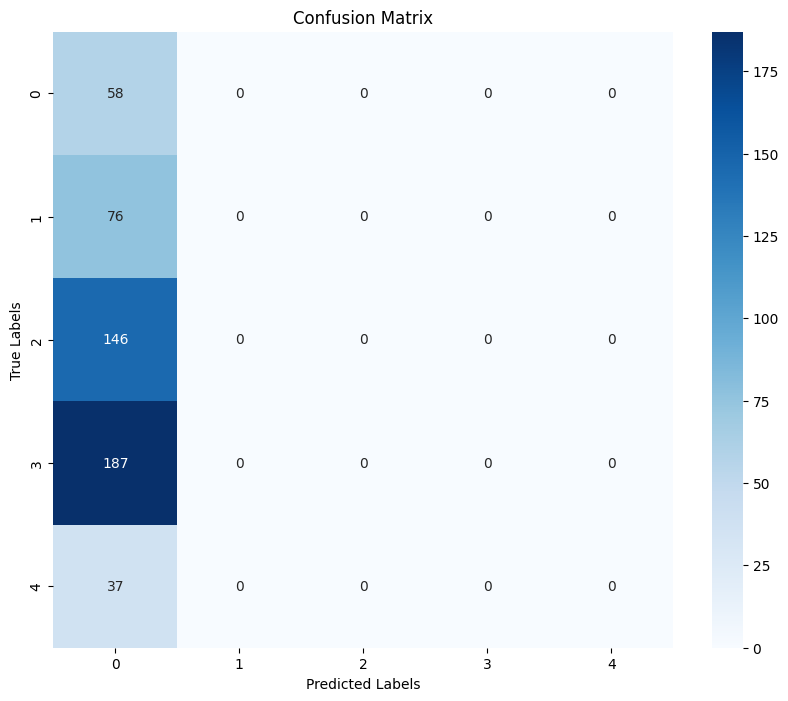

In [20]:
#

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step


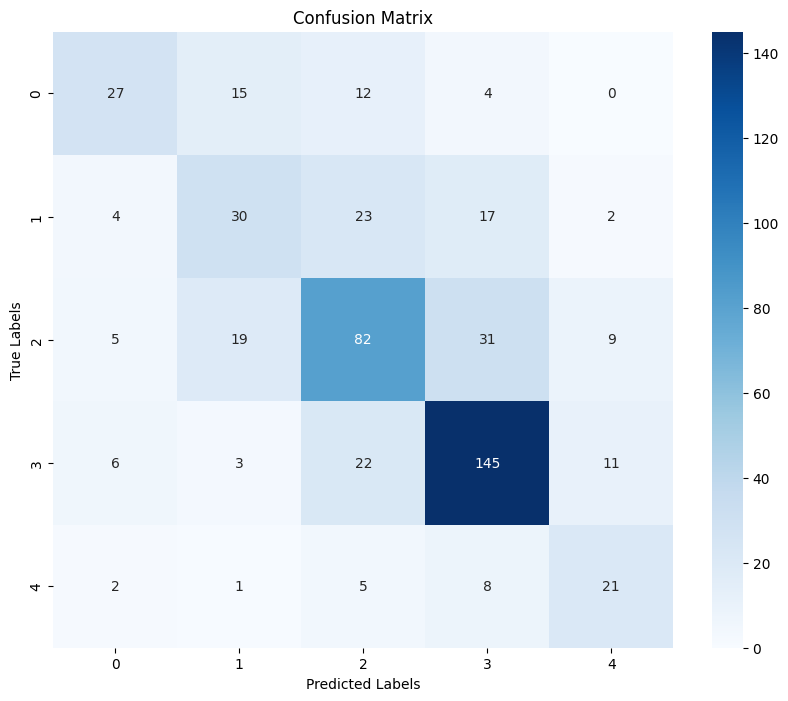

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
X_val_1 = X_val/ 255.0
# Predict the labels for the validation set
y_val_pred = model.predict(X_val_1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)



# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique, yticklabels=unique)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


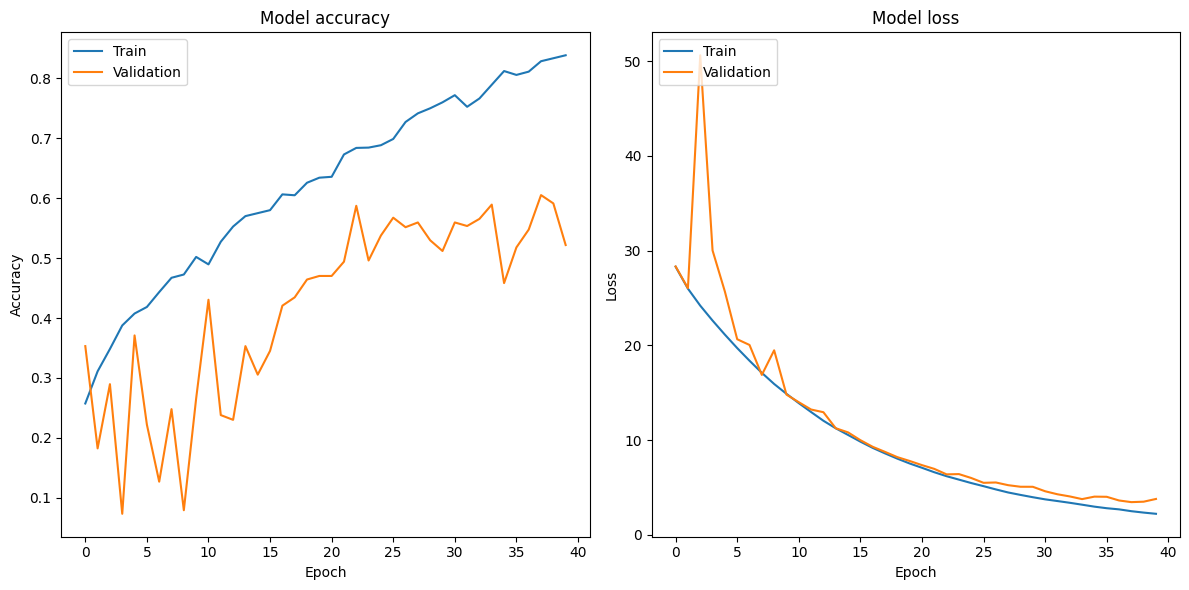

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

plt.show()